In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
import sys
sys.path.append('..')

In [3]:
import sshutils
import mysecrets
import sqlite_db_utils
import rsutils.s2_grid_utils

/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
LOCAL_DATACUBE_FOLDERPATH = '../data/datacubes'

In [5]:
LOCAL_DATACUBE_CATALOG_DB_PATH = sshutils.download_file_from_cluster(
    sshcreds = mysecrets.SSH_UMD,
    remotepath = '/gpfs/data1/cmongp2/sasirajann/fetch_satdata/data/datacubes/catalog.db',
    download_folderpath = LOCAL_DATACUBE_FOLDERPATH,
    overwrite = True,
)

try:
    sshutils.download_file_from_cluster(
        sshcreds = mysecrets.SSH_UMD,
        remotepath = '/gpfs/data1/cmongp2/sasirajann/fetch_satdata/data/datacubes/catalog.db-shm',
        download_folderpath = LOCAL_DATACUBE_FOLDERPATH,
        overwrite = True,
    )
    sshutils.download_file_from_cluster(
        sshcreds = mysecrets.SSH_UMD,
        remotepath = '/gpfs/data1/cmongp2/sasirajann/fetch_satdata/data/datacubes/catalog.db-wal',
        download_folderpath = LOCAL_DATACUBE_FOLDERPATH,
        overwrite = True,
    )
    print('wal and shm files downloaded')
except Exception as e:
    raise e

wal and shm files downloaded


In [6]:
sqlite_db_utils.get_tables_in_db(
    database = LOCAL_DATACUBE_CATALOG_DB_PATH,
)

['sentinel-2-l2a']

In [7]:
s2l2a_datacube_catalog_gdf = sqlite_db_utils.fetch_rows_from_db(
    database = LOCAL_DATACUBE_CATALOG_DB_PATH,
    table = 'sentinel-2-l2a',
    timestamp_cols = ['last_update', 'startdate', 'enddate']
)

In [8]:
s2l2a_datacube_catalog_gdf.tail()

,id,roi,startdate,enddate,config_id,local_folderpath,files,last_update
12803,s2grid=164b2dc_20190305T075733_20200129T075728_1,s2grid=164b2dc,2019-03-05 07:57:33.460000+00:00,2020-01-29 07:57:28.076000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-14 13:09:43.505000+00:00
12804,s2grid=17b4cec_20210304T075734_20220128T075732_1,s2grid=17b4cec,2021-03-04 07:57:34.807000+00:00,2022-01-28 07:57:32.287000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-14 13:10:05.807000+00:00
12805,s2grid=165001c_20190303T080648_20200127T080704_1,s2grid=165001c,2019-03-03 08:06:48.785000+00:00,2020-01-27 08:07:04.521000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-14 13:10:14.380000+00:00
12806,s2grid=17b4cf4_20210304T075734_20220128T075747_1,s2grid=17b4cf4,2021-03-04 07:57:34.807000+00:00,2022-01-28 07:57:47.121000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-14 13:12:32.512000+00:00
12807,s2grid=1650014_20190303T080648_20200127T080704_1,s2grid=1650014,2019-03-03 08:06:48.785000+00:00,2020-01-27 08:07:04.521000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-14 13:15:05.752000+00:00


In [9]:
s2l2a_datacube_catalog_gdf[s2l2a_datacube_catalog_gdf['roi'] == 's2grid=17b4eec']

,id,roi,startdate,enddate,config_id,local_folderpath,files,last_update
9722,s2grid=17b4eec_20210304T075749_20220128T075747_1,s2grid=17b4eec,2021-03-04 07:57:49.172000+00:00,2022-01-28 07:57:47.121000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-12 16:14:14.564000+00:00
9776,s2grid=17b4eec_20190305T075747_20200129T075745_1,s2grid=17b4eec,2019-03-05 07:57:47.839000+00:00,2020-01-29 07:57:45.607000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-12 16:45:12.123000+00:00
10278,s2grid=17b4eec_20200304T075745_20210128T075753_1,s2grid=17b4eec,2020-03-04 07:57:45.826000+00:00,2021-01-28 07:57:53.635000+00:00,1,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"datacube.npy,metadata.pickle.npy,mean_sun_angl...",2025-03-13 12:38:52.110000+00:00


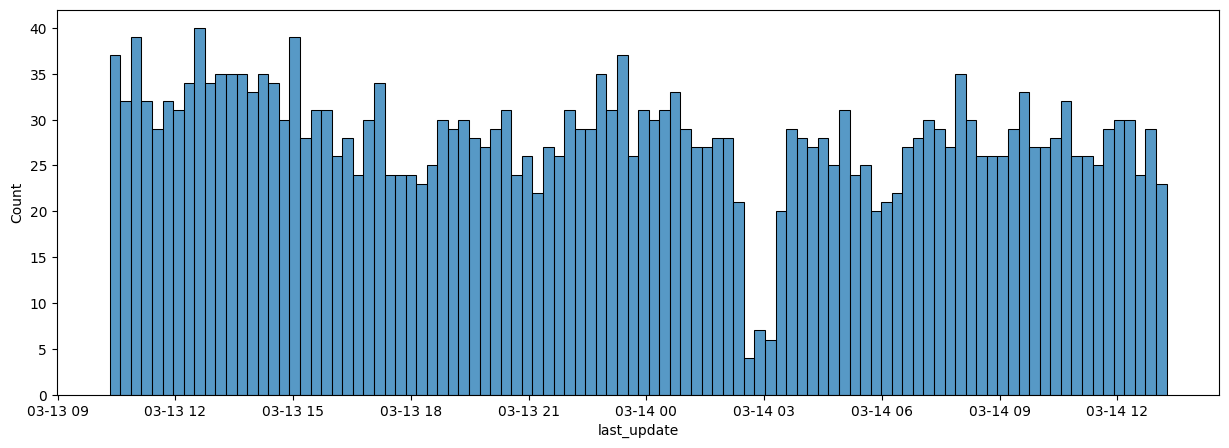

In [21]:
scale = 5
aspect_ratio = 3
fig, ax = plt.subplots(figsize=(scale*aspect_ratio, scale))

filtered_s2l2a_datacube_catalog_gdf = s2l2a_datacube_catalog_gdf[
    (s2l2a_datacube_catalog_gdf['roi'].str.startswith('s2grid=')) &
    # (s2l2a_datacube_catalog_gdf['last_update'] > pd.Timestamp(2024, 2, 25, tz='UTC'))
    (s2l2a_datacube_catalog_gdf['last_update'] > pd.Timestamp(2025, 3, 13, tz='UTC'))
]

g = sns.histplot(
    ax = ax,
    data = filtered_s2l2a_datacube_catalog_gdf,
    x = 'last_update',
    bins = 100,
)

In [22]:
d = 50

last_updates = filtered_s2l2a_datacube_catalog_gdf['last_update'].sort_values().to_numpy()
t_deltas = np.array([
    (last_updates[i+d] - last_updates[i]).total_seconds()
    for i in range(0, last_updates.shape[0]-d)
])

print('shape =', t_deltas.shape)
print('min =', t_deltas.min())
print('max =', t_deltas.max())

shape = (2769,)
min = 1158.671
max = 4627.255


In [23]:
last_updates.shape

(2819,)

In [25]:
done_times = last_updates
n_cores = 10

(done_times[-1] - done_times[0]).seconds / done_times.shape[0] * n_cores

37.346576800283785

Text(0.5, 1.0, 'Datacube creation rate (d=50)')

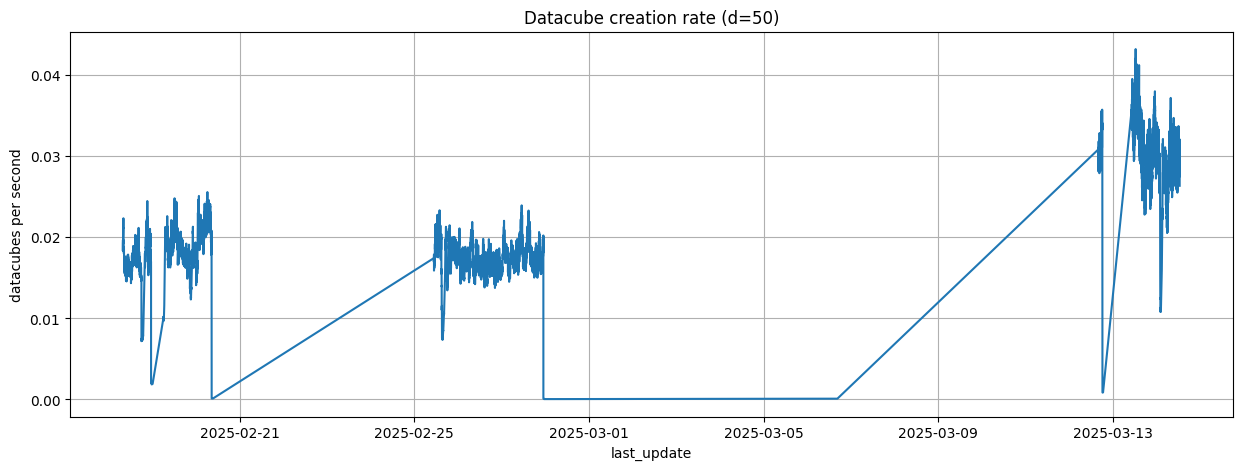

In [13]:
scale = 5
aspect_ratio = 3
fig, ax = plt.subplots(figsize=(scale*aspect_ratio, scale))

g = sns.lineplot(
    ax = ax,
    data = {
        'index': list(range(t_deltas.shape[0])),
        't_deltas': t_deltas,
        'datacubes per second': d / t_deltas,
        'last_update': last_updates[:t_deltas.shape[0]]
    },
    y = 'datacubes per second',
    # x = 'index'
    x = 'last_update',

)
g.grid()
g.set_title(f'Datacube creation rate (d={d})')

In [14]:
s2grids_datacubes_present = s2l2a_datacube_catalog_gdf[
    s2l2a_datacube_catalog_gdf['roi'].str.startswith('s2grid=')
]['roi'].str.removeprefix('s2grid=').unique()

s2grids_datacubes_present

array(['166ae84', '16546ac', '1654334', ..., '164ca7c', '164ca84',
       '164ae24'], dtype=object)

In [15]:
gpd.GeoDataFrame(
    data = {
        's2grid': s2grids_datacubes_present,
        'geometry': [
            rsutils.s2_grid_utils.get_grid_geometry_from_id(grid_id=grid_id)
            for grid_id in s2grids_datacubes_present
        ],
    },
    crs = 'epsg:4326'
).to_file('../data/ethiopia/s2grids_with_datacubes.geojson')

In [16]:
s2l2a_datacube_catalog_gdf['local_folderpath'].to_list()[-1]

'/gpfs/data1/cmongp2/sasirajann/fetch_satdata/data/datacubes/s2l2a/s2grid=1650014/20190303T080648_20200127T080704/1'

### Get failed rois

In [ ]:
with open('../data/ethiopia/inference_rois_except_wolayita.txt') as f:
    inference_rois = [l[:-1] for l in f.readlines()]

len(inference_rois)

In [ ]:
s2l2a_datacube_catalog_gdf[s2l2a_datacube_catalog_gdf['roi'].isin(inference_rois)].to_csv('../data/ethiopia/model_deploy_input_exceptwolayita_2019-2021.csv', index=False)

In [ ]:
year_failed_rois_dict = dict()

for year in [2019, 2020, 2021]:
    year_failed_rois_dict[year] = set(inference_rois) - set(s2l2a_datacube_catalog_gdf[
        (s2l2a_datacube_catalog_gdf['startdate'] > pd.Timestamp(year, 3, 1, tz='UTC')) &
        (s2l2a_datacube_catalog_gdf['startdate'] < pd.Timestamp(year, 3, 10, tz='UTC'))
    ]['roi'])

year_failed_rois_dict

In [ ]:
def s2grids_list_to_gdf(
    s2gridids:list[str],
):
    data = {
        's2gridid': [],
        'geometry': [],
    }
    for s2gridid in s2gridids:
        geometry = rsutils.s2_grid_utils.get_grid_geometry_from_id(s2gridid)
        data['s2gridid'].append(s2gridid)
        data['geometry'].append(geometry)

    return gpd.GeoDataFrame(data=data, crs='epsg:4326')

In [ ]:
with open('../data/ethiopia/inference_rois.txt') as f:
    s2gridids = [line[:-1].removeprefix('s2grid=') for line in f.readlines()]

s2grids_list_to_gdf(s2gridids = s2gridids).to_file('../data/ethiopia/inference_rois.geojson')

In [13]:
1768 / 104 * (2*60 + 16 + 456.23) / 60

167.7985

In [12]:
((2*60 + 41) * 60 + 22) / 60

161.36666666666667

In [1]:
9902.17 / 60 / 60

2.750602777777778

In [2]:
0.75 * 60

45.0

In [14]:
1200.0 / 60

20.0

In [15]:
20 / 3

6.666666666666667

In [ ]:
1 + 30 + 32 + 32 + 9.6 + 11 + 11 + 40 + 1.5 + 11 + 9.9 + 11 + 771/1000

200.771

In [8]:
180 * 100 * 100 / (5 * 5) / 60

1200.0

In [ ]:
data = {
    'year': [],
    's2gridid': [],
    'geometry': [],
}

for year, rois in year_failed_rois_dict.items():
    for roi in rois:
        s2gridid = roi.removeprefix('s2grid=')
        geometry = rsutils.s2_grid_utils.get_grid_geometry_from_id(s2gridid)
        data['year'].append(year)
        data['s2gridid'].append(s2gridid)
        data['geometry'].append(geometry)

failed_rois_gdf = gpd.GeoDataFrame(data=data, crs='epsg:4326')
failed_rois_gdf.to_file('../data/ethiopia/failed_s2grids.geojson')

### Checking failed datacubes

In [ ]:
inputs_df = pd.read_csv('../data/ethiopia/inference2019_wolayita2020-2021_s2l2a_datacube_input.csv')
inputs_df['startdate'] = inputs_df['startdate'].apply(sqlite_db_utils.str_to_ts)
inputs_df['enddate'] = inputs_df['enddate'].apply(sqlite_db_utils.str_to_ts)

In [ ]:
failed_indexes = list(set(zip(
    inputs_df['roi'],
    inputs_df['startdate'],
    inputs_df['enddate'],
    inputs_df['config_id'],
)) - set(zip(
    s2l2a_datacube_catalog_gdf['roi'],
    s2l2a_datacube_catalog_gdf['startdate'],
    s2l2a_datacube_catalog_gdf['enddate'],
    s2l2a_datacube_catalog_gdf['config_id'],
)))
failed_indexes

In [ ]:
failed_inputs_df = \
inputs_df.set_index([
    'roi',
    'startdate',
    'enddate',
    'config_id',
]).loc[failed_indexes].reset_index()

In [ ]:
def get_shapes_gdf(roi:str):
    geom_type, geom_id = roi.split('=')
    if geom_type not in ['s2grid', 'geom']:
        raise ValueError(f'Invalid roi={roi}. roi must start with s2grid= or geom=')
    
    if geom_type == 's2grid':
        geom = rsutils.s2_grid_utils.get_grid_geometry_from_id(grid_id = geom_id)
    else:
        raise NotImplementedError()

    shapes_gdf = gpd.GeoDataFrame(
        data = {'geometry': [geom]},
        crs = 'epsg:4326',
    )

    return shapes_gdf

In [ ]:
failed_inputs_df['geometry'] = failed_inputs_df['roi'].apply(lambda x: get_shapes_gdf(x)['geometry'][0])

In [ ]:
failed_inputs_gdf = gpd.GeoDataFrame(failed_inputs_df, crs='epsg:4326')

In [ ]:
failed_inputs_gdf.to_file('../data/ethiopia/failed_inputs.geojson')

### Creating training datacube ids list

In [ ]:
with open('../data/ethiopia/training_datacube_ids.txt', 'w') as f:
    for _id in s2l2a_datacube_catalog_gdf[s2l2a_datacube_catalog_gdf['id'].str.startswith('geom=')]['id']:
        f.write(f'{_id}\n')

### Creating crops.npy

In [ ]:
import numpy as np
import geopandas as gpd

In [ ]:
data = np.load('../data/ethiopia/s2l2a_training_data/data.npy')
ids = np.load('../data/ethiopia/s2l2a_training_data/ids.npy', allow_pickle=True)[()]

In [ ]:
data.shape

In [ ]:
training_data_gdf = gpd.read_file('../data/ethiopia/normalised/combined.geojson')

In [ ]:
ids[0].split('=')[1].split('_')[:-3]

In [ ]:
training_data_gdf['id']

In [ ]:
id_crop_dict = dict(zip(
    training_data_gdf['id'],
    training_data_gdf['c_class'],
))

In [ ]:
crops = []
for _id in ids:
    _id = '_'.join(_id.split('=')[1].split('_')[:-3])
    crops.append(id_crop_dict[_id])

crops = np.array(crops)

In [ ]:
np.save('../data/ethiopia/s2l2a_training_data/crops.npy', crops)